---
title: Lab 4 Coffee
author: Marvin (Wenxiang) Li
format:
    html:
        toc: true
        code-fold: true
embed-resources: true
---

### 1. Scrape the Location Counts

- import all needed packages

In [1]:
import pandas as pd
import requests
import re
from bs4 import BeautifulSoup
import plotnine as p9

- use bs4 to parse html

In [2]:
url = "https://worldpopulationreview.com/state-rankings/starbucks-stores-by-state"

- check if page was access sucessfully

In [3]:
page = requests.get(url)
page

<Response [200]>

- parser html 

In [4]:
soup = BeautifulSoup(page.content, "html.parser")

- check number of tables

In [5]:
len(soup.find_all("table"))

1

In [6]:
table = soup.find_all("table")[0]

- unit test

- find all rows

In [7]:
state = table.find_all("tr") # 52 rows can be looped later
len(state)

52

- find all 'th' tags

In [8]:
state_th = state[12].find_all("th") # scape 1 state name
state_th

[<th class="text-wpr-table_header sticky left-0 z-50 bg-clip-padding py-1.5 pl-3 text-left align-middle text-sm md:px-4"><a class="text-wpr-link" href="/states/pennsylvania" to="/states/pennsylvania">Pennsylvania</a></th>]

- extract state from 'th' tag

In [9]:
state_th = state[5].find_all("th") # scape 1 state name
state_tag = state_th[0].find_all("a")
state_name = state_tag[0].text.strip()
state_name

'New York'

- extracting store locations

In [10]:
state_td = state[5].find_all("td")
state_loc0 = state_td[0].text.strip()
state_loc1 = state_td[1].text.strip()
state_loc2 = state_td[2].text.strip()
print(state_loc0, state_loc1, state_loc2)

692 643 715


- extracting column names for automation

In [11]:
th_tag = state[0].find_all("th") # scape column names
th1 = th_tag[1].text
th2 = th_tag[2].text
th3 = th_tag[3].text
print(th1, th2, th3)

Starbucks Stores 2023 Starbucks Stores 2021 Starbucks Stores 2024


- scarpe Starbuck

In [12]:
# extract chain name
title = soup.find("h1")
chain_name = title.text.strip().split()[0]
# extracting column name
header = table.find_all("tr")
th_tag = header[0].find_all("th")
first_col = th_tag[1].text
year_0 = re.findall(r'\d{4}', first_col)
year_0 = ''.join(year_0)
second_col = th_tag[2].text
year_1 = re.findall(r'\d{4}', second_col)
year_1 = ''.join(year_1)
if len(th_tag) > 3:
    third_col = th_tag[3].text
    year_2 = re.findall(r'\d{4}', third_col)
    year_2 = ''.join(year_2)
rows1 = []
for state in table.find_all("tr")[1:]:
    # find state in th tag
    state_th = state.find_all("th") 
    state_tag = state_th[0].find_all("a")
    state_name = state_tag[0].text.strip()
    # find location
    state_td = state.find_all("td")
    state_loc0 = state_td[0].text.strip()
    state_loc1 = state_td[1].text.strip()
    if len(state_td) > 2:     # suggested by Chat to work for Dunkin
        state_loc2 = state_td[2].text.strip()

    # make table
    if len(state_td) > 2:     # suggested by Chat to work for Dunkin
      rows1.append({
        "state": state_name,
        f"{year_0}": state_loc0,
        f"{year_1}": state_loc1,
        f"{year_2}": state_loc2
      })
    else:
      rows1.append({
        "state": state_name,
        f"{year_0}": state_loc0,
        f"{year_1}": state_loc1
      })
star = pd.DataFrame(rows1)
# wide to long
star_long = star.melt(id_vars=["state"], var_name='year', value_name='store')
star_long['chain'] = f"{chain_name}" # f string suggested by Chat 

In [13]:
star_long.head(3)

,state,year,store,chain
0,California,2023,"3,080",Starbucks
1,Texas,2023,"1,346",Starbucks
2,Florida,2023,844,Starbucks


- scrape Dunkin’ Donuts using rating() version 0

In [14]:
def rating_0(url):
  # get soup
  page = requests.get(url)
  soup = BeautifulSoup(page.content, "html.parser")
  table = soup.find_all("table")[0]
  # extract chain name
  title = soup.find("h1")
  chain_name = title.text.strip().split()[0]
  # extracting 'year'
  header = table.find_all("tr")
  th_tag = header[0].find_all("th")
  first_col = th_tag[1].text
  year_0 = re.findall(r'\d{4}', first_col)
  year_0 = ''.join(year_0)
  second_col = th_tag[2].text
  year_1 = re.findall(r'\d{4}', second_col)
  year_1 = ''.join(year_1)
  # two web page have different numbers of column; code suggested by Chat
  if len(th_tag) > 3:
    third_col = th_tag[3].text
    year_2 = re.findall(r'\d{4}', third_col)
    year_2 = ''.join(year_2)

  # automation
  rows = []
  for state in table.find_all("tr")[1:]:
      # find state in th tag
      state_th = state.find_all("th") 
      state_tag = state_th[0].find_all("a")
      state_name = state_tag[0].text.strip()
      # find location
      state_td = state.find_all("td")
      state_loc0 = state_td[0].text.strip()
      state_loc1 = state_td[1].text.strip()
      if len(state_td) > 2:
        state_loc2 = state_td[2].text.strip()

      # make table
      if len(state_td) > 2:   # for Dunkin with less column
        rows.append({
          "state": state_name,
          f"{year_0}": state_loc0, # use year extracted from tr0
          f"{year_1}": state_loc1,
          f"{year_2}": state_loc2  # f string suggested by Chat
          })
      else:
        rows.append({
          "state": state_name,
          f"{year_0}": state_loc0, # f string suggested by Chat
          f"{year_1}": state_loc1
      })
  df = pd.DataFrame(rows)
  df_long = df.melt(id_vars=["state"], var_name='year', value_name='store')
  df_long['chain'] = f"{chain_name}"
  return df_long

In [15]:
donut_long = rating_0("https://worldpopulationreview.com/state-rankings/dunkin-donuts-by-state")
donut_long.head(5)

,state,year,store,chain
0,New York,2024,"1,431",Dunkin
1,Massachusetts,2024,"1,042",Dunkin
2,Florida,2024,909,Dunkin
3,New Jersey,2024,872,Dunkin
4,Illinois,2024,711,Dunkin


- concatnate to coffee tables

In [16]:
coffee_long = pd.concat([star_long, donut_long], ignore_index=True)
coffee_long

,state,year,store,chain
0,California,2023,"3,080",Starbucks
1,Texas,2023,"1,346",Starbucks
2,Florida,2023,844,Starbucks
3,Washington,2023,741,Starbucks
4,New York,2023,692,Starbucks
...,...,...,...,...
250,Montana,2023,0,Dunkin
251,North Dakota,2023,0,Dunkin
252,Oregon,2023,0,Dunkin
253,South Dakota,2023,0,Dunkin


### 2. Supplemental Data

- scrape population

In [17]:
url_2 = "https://simple.wikipedia.org/wiki/List_of_U.S._states_by_population"
page_2 = requests.get(url_2)
soup_2 = BeautifulSoup(page_2.content, "html.parser")
table_2 = soup_2.find_all("table")[0]
rows2 = []
for tr2 in table_2.find_all("tr")[1:57]: # 0 and 57 beyond are not useful
  # find state
  td2 = tr2.find_all("td")
  ta2 = td2[2].find_all("a")
  state_2 = ta2[0].text.strip()
  # find population
  population = td2[3].text.strip()

  rows2.append({
        "state": state_2,
        "population": population
      })
df2 = pd.DataFrame(rows2)

In [18]:
df2[0:5]

,state,population
0,California,"39,538,223"
1,Texas,"30,145,505"
2,Florida,"21,538,187"
3,New York,"20,201,249"
4,Pennsylvania,"13,002,700"


- merge population

In [19]:
coffee_big = coffee_long.merge(df2, on=["state"])
coffee_big.head(5)

,state,year,store,chain,population
0,California,2023,"3,080",Starbucks,"39,538,223"
1,Texas,2023,"1,346",Starbucks,"30,145,505"
2,Florida,2023,844,Starbucks,"21,538,187"
3,Washington,2023,741,Starbucks,"7,705,281"
4,New York,2023,692,Starbucks,"20,201,249"


- input business metrics

In [20]:
revenue = {
    'chain': ['Starbucks',  'Dunkin'],
    'year': [2023, 2023],
    'revenue': [26569, 11918],
    'avg_price': [4.15, 2.49], 
}
# Create DataFrame
revenue = pd.DataFrame(revenue)
revenue['year'] = revenue['year'].astype(str)
print(revenue)

       chain  year  revenue  avg_price
0  Starbucks  2023    26569       4.15
1     Dunkin  2023    11918       2.49


- create region column

In [21]:
mask_reg1 = coffee_big['state'].isin(['Connecticut', 'Maine', 'Massachusetts',
                                      'New Hampshire', 'Rhode Island',
                                      'Vermont', 'New Jersey', 'New York',
                                      'Pennsylvania'])
mask_reg2 = coffee_big['state'].isin(['Illinois', 'Indiana', 'Michigan', 'Ohio',
                                      'Wisconsin', 'Iowa', 'Kansas', 'Minnesota',
                                      'Missouri', 'Nebraska', 'North Dakota',
                                      'South Dakota'])
mask_reg3 = coffee_big['state'].isin(['Delaware', 'Florida', 'Georgia', 'Maryland',
                                      'North Carolina', 'South Carolina', 'Virginia',
                                      'District of Columbia', 'West Virginia', 'Texas',
                                      'Alabama', 'Kentucky', 'Mississippi',
                                      'Arkansas', 'Louisiana', 'Oklahoma','Tennessee'])
mask_reg4 = coffee_big['state'].isin(['Arizona', 'Colorado', 'Idaho', 'Montana',
                                      'Nevada', 'New Mexico', 'Utah', 'Wyoming',
                                      'Alaska', 'California', 'Hawaii', 'Oregon',
                                      'Washington'])

# Apply the mask to update the 'region' column
coffee_big.loc[mask_reg1, 'region'] = 'Northeast'
coffee_big.loc[mask_reg2, 'region'] = 'Midwest'
coffee_big.loc[mask_reg3, 'region'] = 'South'
coffee_big.loc[mask_reg4, 'region'] = 'West'

In [22]:
coffee_big.head(5)

,state,year,store,chain,population,region
0,California,2023,"3,080",Starbucks,"39,538,223",West
1,Texas,2023,"1,346",Starbucks,"30,145,505",South
2,Florida,2023,844,Starbucks,"21,538,187",South
3,Washington,2023,741,Starbucks,"7,705,281",West
4,New York,2023,692,Starbucks,"20,201,249",Northeast


- merge metric data

In [23]:
coffee_final = coffee_big.merge(revenue, on=["chain", "year"], how="left")
coffee_final.head(5)

,state,year,store,chain,population,region,revenue,avg_price
0,California,2023,"3,080",Starbucks,"39,538,223",West,26569.0,4.15
1,Texas,2023,"1,346",Starbucks,"30,145,505",South,26569.0,4.15
2,Florida,2023,844,Starbucks,"21,538,187",South,26569.0,4.15
3,Washington,2023,741,Starbucks,"7,705,281",West,26569.0,4.15
4,New York,2023,692,Starbucks,"20,201,249",Northeast,26569.0,4.15


- convert strings to numbers for analysis

In [24]:
# code suggested by Chat
coffee_final['population'] = pd.to_numeric(coffee_final['population'].astype(str).str.replace(',', ''), errors='coerce')
coffee_final['store'] = pd.to_numeric(coffee_final['store'].astype(str).str.replace(',', ''), errors='coerce')
coffee_final.head()

,state,year,store,chain,population,region,revenue,avg_price
0,California,2023,3080.0,Starbucks,39538223,West,26569.0,4.15
1,Texas,2023,1346.0,Starbucks,30145505,South,26569.0,4.15
2,Florida,2023,844.0,Starbucks,21538187,South,26569.0,4.15
3,Washington,2023,741.0,Starbucks,7705281,West,26569.0,4.15
4,New York,2023,692.0,Starbucks,20201249,Northeast,26569.0,4.15


### 3. Analyze

- extract 2023 data for comparison
- location for Starbucks 2024 is incomplete
- location for Dunkin 2021 is missing

In [25]:
coffee_final_2023 = coffee_final[coffee_final['year'] == "2023"]
coffee_final_2023.head(5)

,state,year,store,chain,population,region,revenue,avg_price
0,California,2023,3080.0,Starbucks,39538223,West,26569.0,4.15
1,Texas,2023,1346.0,Starbucks,30145505,South,26569.0,4.15
2,Florida,2023,844.0,Starbucks,21538187,South,26569.0,4.15
3,Washington,2023,741.0,Starbucks,7705281,West,26569.0,4.15
4,New York,2023,692.0,Starbucks,20201249,Northeast,26569.0,4.15


- Does the distribution of each chain’s stores match population distribution, by both state/region?
- ploting the relation between number of store and populaton

/opt/anaconda3/lib/python3.12/site-packages/IPython/lib/pretty.py:779: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().
/opt/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/opt/anaconda3/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


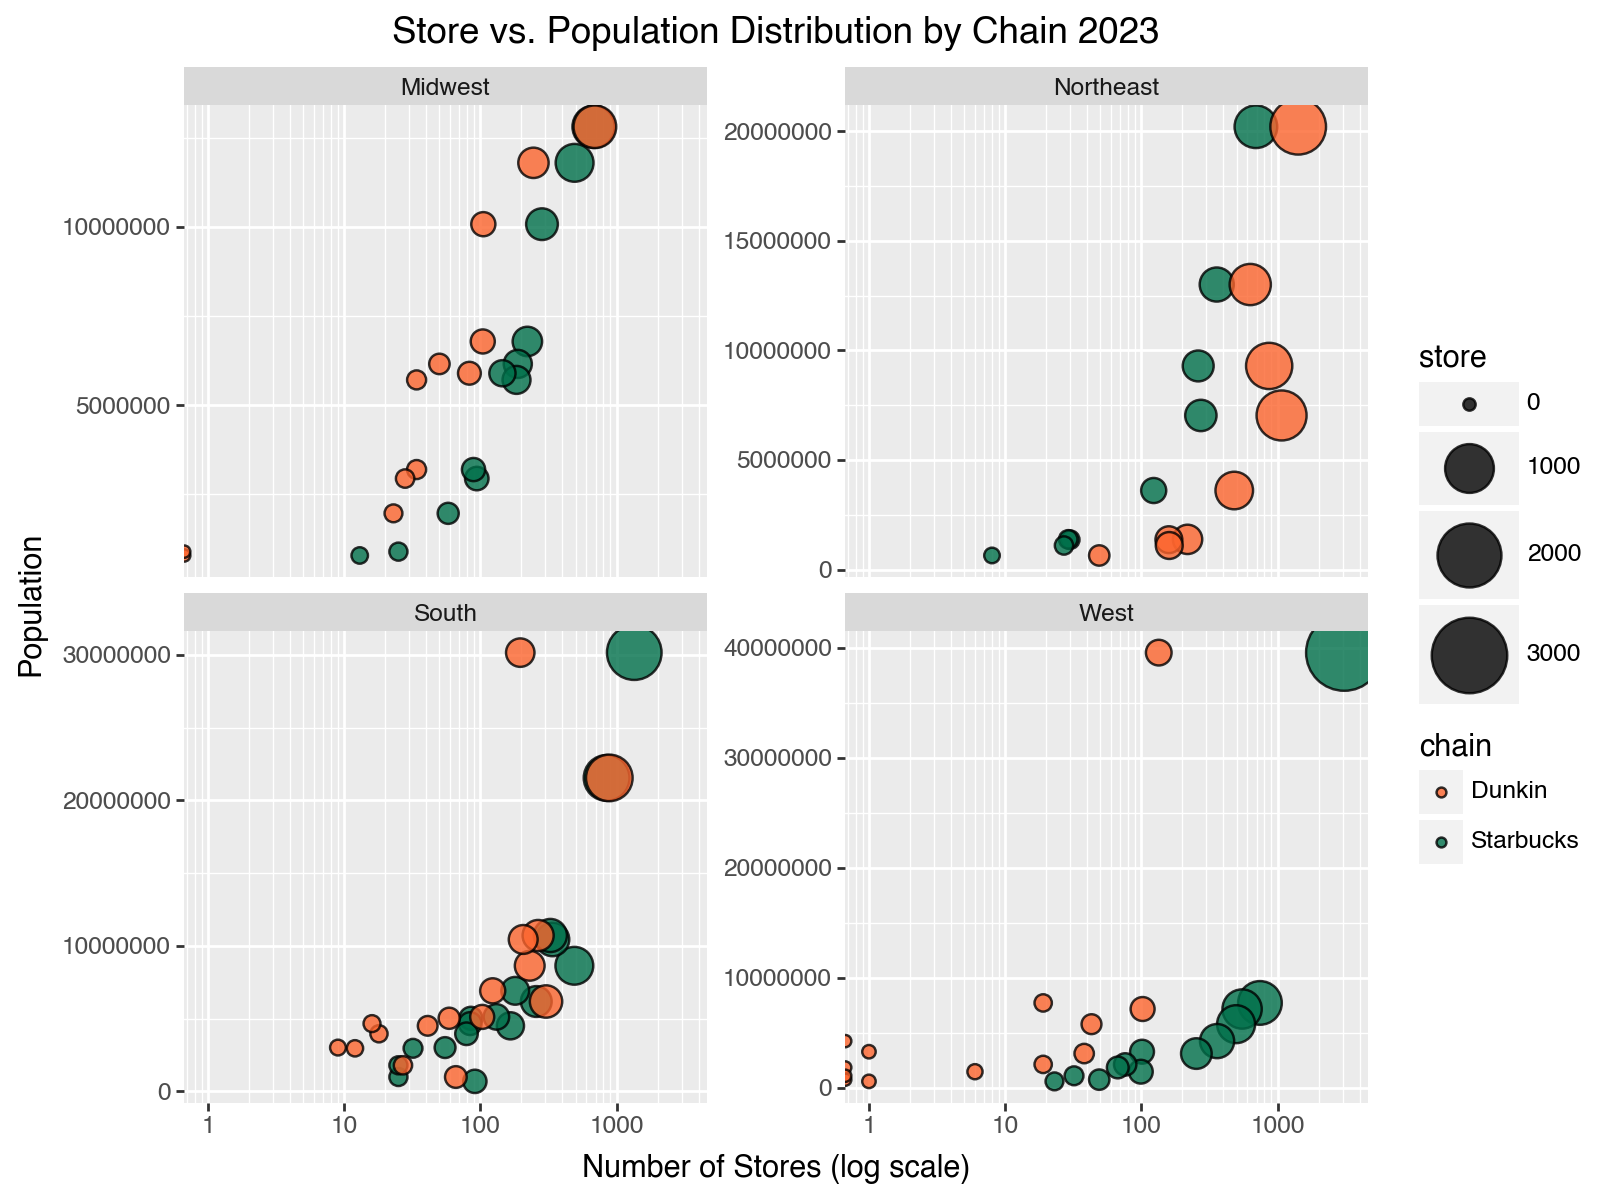

[<Figure Size: (800 x 600)>]

In [26]:
[p9.ggplot(coffee_final_2023) +
 p9.geom_point(p9.aes(x = "store", y= "population", fill = 'chain', size = 'store'), alpha = 0.8) +
 p9.scale_x_log10() +
 p9.scale_size(range=(2, 15)) +
 p9.labs(title="Store vs. Population Distribution by Chain 2023",
            x="Number of Stores (log scale)",
            y="Population"
        ) +
 p9.facet_wrap("region",scales='free_y') +
 p9.theme(figure_size=(8, 6)) +
 p9.scale_fill_manual(values={"Starbucks": "#00704A", "Dunkin": "#FC642D"})
]

- There appears to be a weak positive correlation between Number of stores and population of a state. Larger state tend to have more stores. It is not suprised that the two chains adapted the same strategy. 

- Are some of these chains more prevalent in certain states than others? Possibly despite having less stores overall? Same questions for regions instead of states.
- plot number of locations to see the percentage of each chain in each state

/opt/anaconda3/lib/python3.12/site-packages/IPython/lib/pretty.py:779: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().
/opt/anaconda3/lib/python3.12/site-packages/plotnine/layer.py:344: PlotnineWarning: position_stack : Removed 1 rows containing missing values.


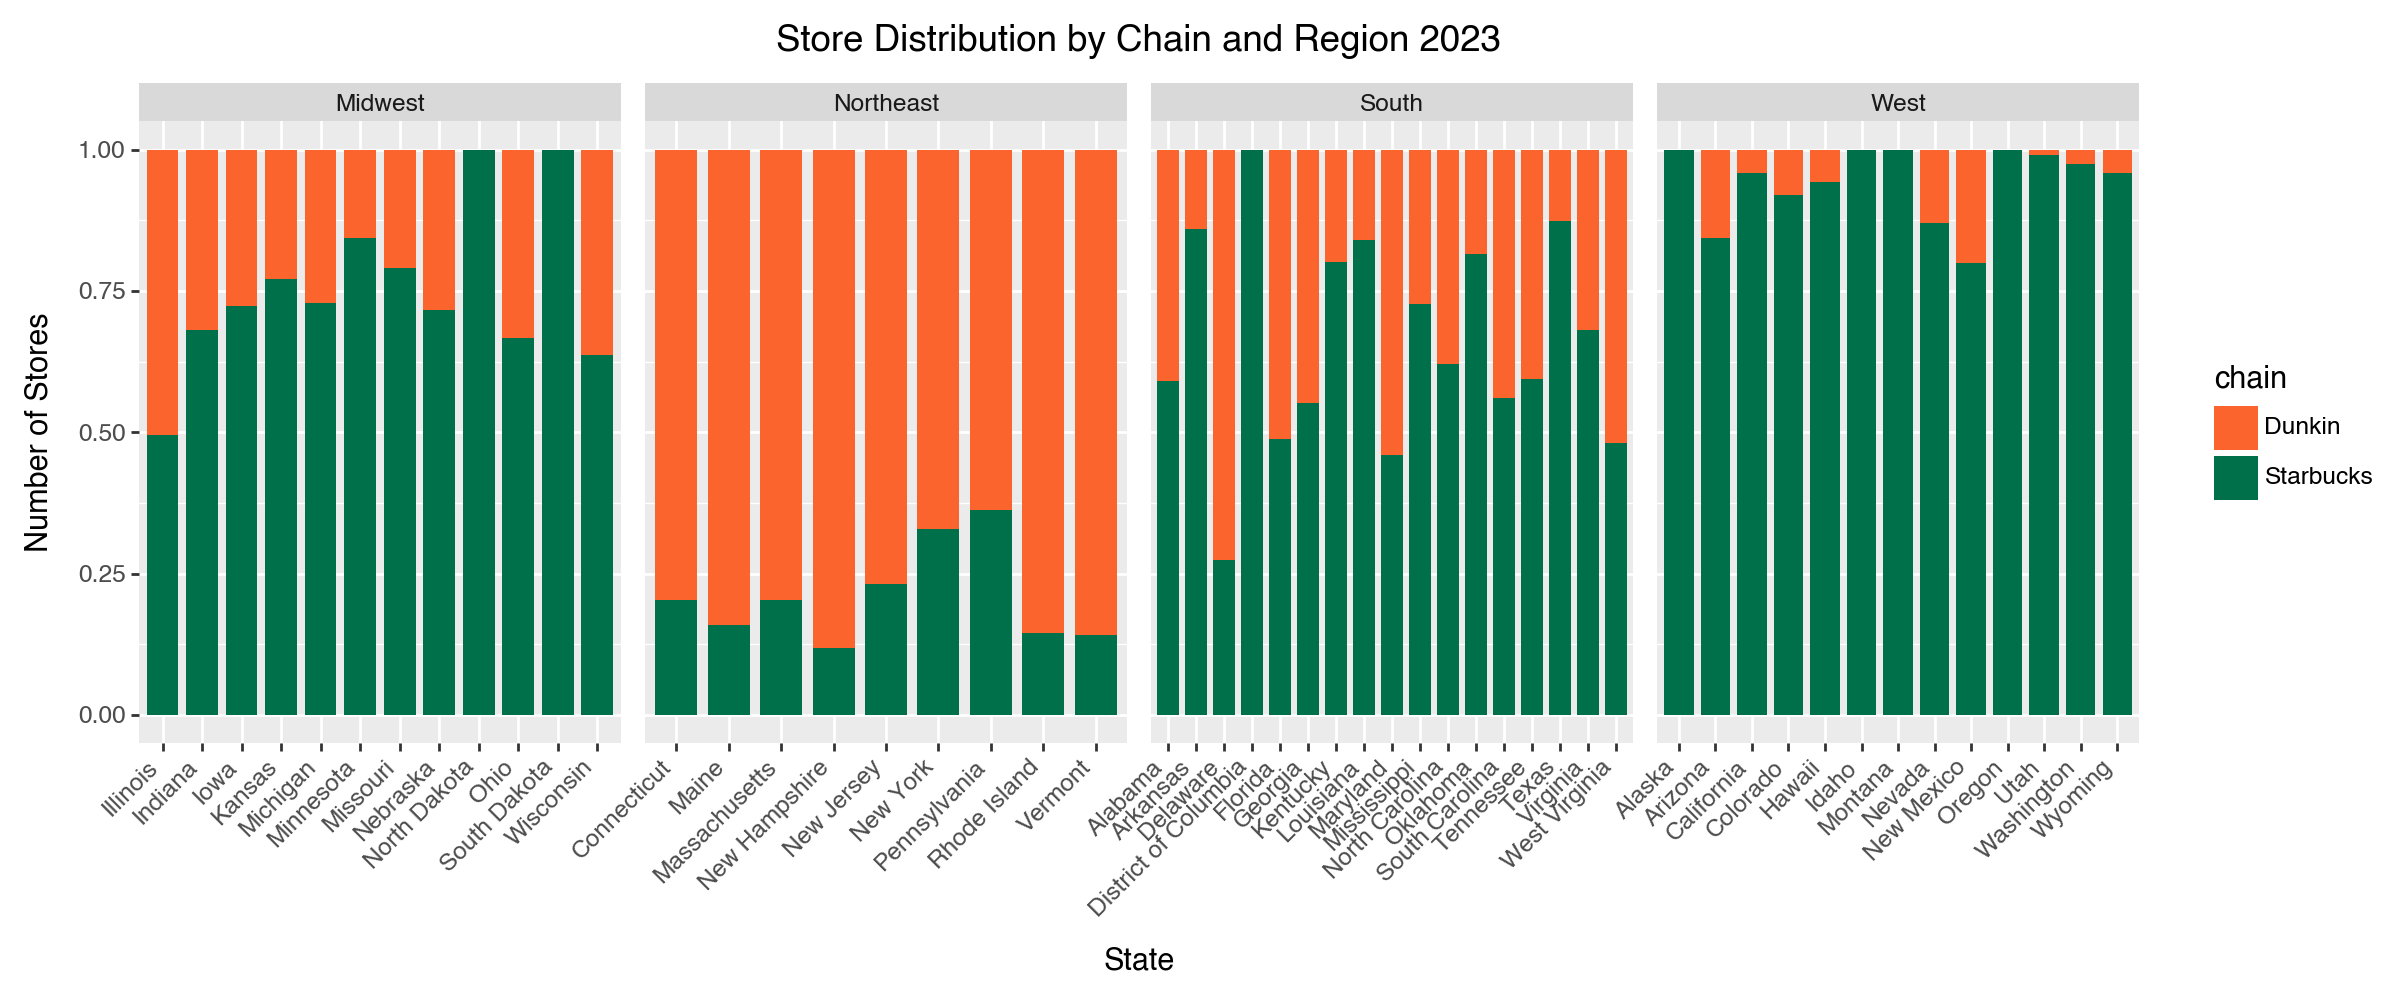

[<Figure Size: (1200 x 500)>]

In [27]:
[p9.ggplot(coffee_final_2023) +
 p9.aes(x="state", y = "store", fill = "chain") +
 p9.geom_col(position = "fill", width = 0.8) +
 p9.theme(
          axis_text_x=p9.element_text(angle=45, hjust=1)) +
 p9.facet_wrap("region", ncol=4, scales='free_x') +
   p9.theme(figure_size=(12, 5)) +
 p9.scale_fill_manual(values={"Starbucks": "#00704A", "Dunkin": "#FC642D"}) +
 p9.labs(title="Store Distribution by Chain and Region 2023",
            x="State",
            y="Number of Stores"
        )
]

- The graph shows that Dunkin has more store in Northeast despite the fact that Starbucks is a larger publicly traded company and has way more total stores in the US. This indicats that Dunkin has a strong location barrier in its base Norteastern states. This may also indicates that Dunkin is more popular in the Northeastern states where it was established.\
On the other hand, Starbucks holds a strong position in the West. Notice, in District of Columbia, Alaska, Idaho, Montana, North Dakota, South Dakota, and Oregon, Dunkin does not have any store in 2023

- Are Starbucks stores more profitable than Dunkin's?
- Compute average profit per store 

In [37]:
result = coffee_final_2023.groupby('chain')['store'].sum()
result = pd.DataFrame(result)
result = result.merge(revenue, on = "chain")
result


,chain,store,year,revenue,avg_price
0,Dunkin,9361.0,2023,11918,2.49
1,Starbucks,14744.0,2023,26569,4.15


In [43]:
# Calculate the average profit per store for each chain
result['avg_profit_per_store'] = result['revenue'] / result['store']
result.loc[:, ["chain", "revenue", "avg_profit_per_store"]]

,chain,revenue,avg_profit_per_store
0,Dunkin,11918,1.273155
1,Starbucks,26569,1.802021


- the result shows that per store annual profit is about 1.27 million dollars and 1.80 million dollars for Starbucks and Dunkin, respectively

### 4. Automate
- Final version of rating()
- rating() convert scrapped data from wide to long, merge with populaton, and create a region column

In [28]:
def rating(url):
  # get soup
  page = requests.get(url)
  soup = BeautifulSoup(page.content, "html.parser")
  table = soup.find_all("table")[0]
  # extract chain name
  title = soup.find("h1")
  chain_name = title.text.strip().split()[0]
  # extracting 'year'
  header = table.find_all("tr")
  th_tag = header[0].find_all("th")
  first_col = th_tag[1].text
  year_0 = re.findall(r'\d{4}', first_col)
  year_0 = ''.join(year_0)
  if len(th_tag) > 2:
    second_col = th_tag[2].text
    year_1 = re.findall(r'\d{4}', second_col)
    year_1 = ''.join(year_1)
  # two web page have different numbers of column; code suggested by Chat
  if len(th_tag) > 3:
    third_col = th_tag[3].text
    year_2 = re.findall(r'\d{4}', third_col)
    year_2 = ''.join(year_2)

  # automation
  rows = []
  for state in table.find_all("tr")[1:]:
      # find state in th tag
      state_th = state.find_all("th") # find all works with single element
      state_tag = state_th[0].find_all("a")
      state_name = state_tag[0].text.strip()
      # find location
      state_td = state.find_all("td")
      state_loc0 = state_td[0].text.strip()
      if len(state_td) > 1:
        state_loc1 = state_td[1].text.strip()
      if len(state_td) > 2:
        state_loc2 = state_td[2].text.strip()

      # make table
      if len(state_td) > 2:   # for Dunkin with less column
        rows.append({
          "state": state_name,
          f"{year_0}": state_loc0, # use year extracted from tr0
          f"{year_1}": state_loc1,
          f"{year_2}": state_loc2  # f string suggested by Chat
          })
      if len(state_td) > 1:   # for Dunkin with less column
        rows.append({
          "state": state_name,
          f"{year_0}": state_loc0, # use year extracted from tr0
          f"{year_1}": state_loc1,
          })
      else:
        rows.append({
          "state": state_name,
          f"{year_0}": state_loc0, # f string suggested by Chat
      })
  df = pd.DataFrame(rows)
  # extracting the population table
  url_2 = "https://simple.wikipedia.org/wiki/List_of_U.S._states_by_population"
  page_2 = requests.get(url_2)
  soup_2 = BeautifulSoup(page_2.content, "html.parser")
  table_2 = soup_2.find_all("table")[0]
  rows2 = []
  for tr2 in table_2.find_all("tr")[1:57]: # 0 and 57 beyond are not useful
    # find state
    td2 = tr2.find_all("td")
    ta2 = td2[2].find_all("a")
    state_2 = ta2[0].text.strip()
    # find population
    population = td2[3].text.strip()

    rows2.append({
        "state": state_2,
        "population": population
      })
  df2 = pd.DataFrame(rows2)
  # merging store and population
  df_merge = df.merge(df2, on=["state"])
  df_long = df_merge.melt(id_vars=["state", "population"], var_name='year', value_name='store')
  # adding chain name
  df_long['chain'] = f"{chain_name}"
  # adding region
  mask_reg1 = df_long['state'].isin(['Connecticut', 'Maine', 'Massachusetts',
                                      'New Hampshire', 'Rhode Island',
                                      'Vermont', 'New Jersey', 'New York',
                                      'Pennsylvania'])
  mask_reg2 = df_long['state'].isin(['Illinois', 'Indiana', 'Michigan', 'Ohio',
                                      'Wisconsin', 'Iowa', 'Kansas', 'Minnesota',
                                      'Missouri', 'Nebraska', 'North Dakota',
                                      'South Dakota'])
  mask_reg3 = df_long['state'].isin(['Delaware', 'Florida', 'Georgia', 'Maryland',
                                      'North Carolina', 'South Carolina', 'Virginia',
                                      'District of Columbia', 'West Virginia', 'Texas',
                                      'Alabama', 'Kentucky', 'Mississippi',
                                      'Arkansas', 'Louisiana', 'Oklahoma','Tennessee'])
  mask_reg4 = df_long['state'].isin(['Arizona', 'Colorado', 'Idaho', 'Montana',
                                      'Nevada', 'New Mexico', 'Utah', 'Wyoming',
                                      'Alaska', 'California', 'Hawaii', 'Oregon',
                                      'Washington'])

  # Apply the mask to update the 'region' column
  df_long.loc[mask_reg1, 'region'] = 'Northeast'
  df_long.loc[mask_reg2, 'region'] = 'Midwest'
  df_long.loc[mask_reg3, 'region'] = 'South'
  df_long.loc[mask_reg4, 'region'] = 'West'

  return df_long


- the Walmart dataset does not have a year column

In [29]:
test = rating("https://worldpopulationreview.com/state-rankings/walmart-stores-by-state")
test[0:5]

,state,population,year,store,chain,region
0,Texas,"30,145,505",,517,Walmart,South
1,Florida,"21,538,187",,341,Walmart,South
2,California,"39,538,223",,280,Walmart,West
3,North Carolina,"10,439,388",,192,Walmart,South
4,Georgia,"10,711,908",,189,Walmart,South


### Source
- https://www.enterpriseappstoday.com/stats/dunkin-statistics.html
- https://www.restaurantbusinessonline.com/top-500-2024-ranking
- https://investor.starbucks.com/news/financial-releases/default.aspx
- https://www.statista.com/statistics/919774/sales-of-selected-leading-coffee-house-and-cafe-chains-in-the-us/